## Introduction to Dask

Dask is a parallel computing library that extends Pandas-like APIs to handle larger-than-memory datasets. It supports lazy evaluation and builds task graphs you can visualize.

In [1]:
# !uv pip install dask

In [2]:
import dask.dataframe as dd

## Reading Parquet 
Dask DataFrame is lazy by default, similar to Spark’s lazy evaluation model. When you perform operations like reading parquet files or creating new columns, Dask builds a task graph of the computation but does not execute it immediately. Actual computation only happens when you explicitly call a method like `.compute()` or certain others like `len` or `head` that trigger computation.

In [3]:
s3file = 's3://techcatalyst-raw/yellow_tripdata_2024-01.parquet'

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
df = dd.read_parquet(s3file)
type(df)

dask.dataframe.dask_expr._collection.DataFrame

In [6]:
print(df)

Dask DataFrame Structure:
              VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance RatecodeID store_and_fwd_flag PULocationID DOLocationID payment_type fare_amount    extra  mta_tax tip_amount tolls_amount improvement_surcharge total_amount congestion_surcharge Airport_fee
npartitions=1                                                                                                                                                                                                                                                                                 
                 int32       datetime64[us]        datetime64[us]         float64       float64    float64             string        int32        int32        int64     float64  float64  float64    float64      float64               float64      float64              float64     float64
                   ...                  ...                   ...             ...           ...        ...       

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [8]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [9]:
df.dtypes

VendorID                           int32
tpep_pickup_datetime      datetime64[us]
tpep_dropoff_datetime     datetime64[us]
passenger_count                  float64
trip_distance                    float64
RatecodeID                       float64
store_and_fwd_flag       string[pyarrow]
PULocationID                       int32
DOLocationID                       int32
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
congestion_surcharge             float64
Airport_fee                      float64
dtype: object

## Calculate Trip Duration (in minutes)

In [10]:
df = df.assign(
    trip_duration_min = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
)
print(df['trip_duration_min'])

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 8 expressions
Expr=Assign(frame=ReadParquetFSSpec(4b38a40))['trip_duration_min']


In [11]:
df_filtered = df[df["trip_duration_min"] > 25]

## Group by aggregation 

In [12]:
result = df_filtered.groupby("payment_type")["fare_amount"].mean()

## Trigger Execution

In order to visualize the exectution graph we will need to install the `graphviz` library
* In the terminal run : `sudo apt udpate`
* Then run `sudo apt install graphviz`
* Finaly, in the terminal to conform installation run `dot -V`

In [13]:
!uv pip install graphviz 

Resolved 1 package in 130ms
Prepared 1 package in 85ms
Installed 1 package in 89ms
 + graphviz==0.21


In [15]:
result.visualize()  # Generates a graph image. LR means left to right 

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

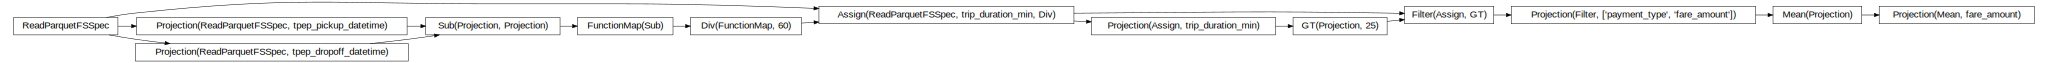

In [ ]:
result.visualize(rankdir="LR")  # Generates a graph image. LR means left to right 

In [ ]:
df_result = result.compute()
df_result

payment_type
0    40.175634
1    49.081101
2    49.536832
3    23.084967
4     4.193730
Name: fare_amount, dtype: float64